# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.3.1'

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [42]:
Vgg16 = tf.keras.applications.VGG16(weights='imagenet',input_shape=(224, 224, 3), include_top=False)
Vgg16.trainable = False
                    
model_base = tf.keras.models.Sequential()
model_base.add(Vgg16)

model_base.add(tf.keras.layers.Flatten())

model_base.add(tf.keras.layers.Dense(256,activation = 'relu',))
model_base.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))


model_base.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


#### [5 points] Train Model

In [43]:
#FIT MODEL

print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size


11
3


In [44]:

model_base.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
    metrics=['acc']
)

In [45]:
result=model_base.fit_generator(train_batches,
 steps_per_epoch =STEP_SIZE_TRAIN,
 validation_data = valid_batches,
 validation_steps = STEP_SIZE_VALID,
 epochs= NUM_EPOCHS,
 )

Epoch 1/40
10/10 [==============================] - 12s 1s/step - loss: 1.7728 - acc: 0.4894 - val_loss: 1.0227 - val_acc: 0.5500
Epoch 2/40
10/10 [==============================] - 13s 1s/step - loss: 0.6502 - acc: 0.7447 - val_loss: 0.3451 - val_acc: 0.9000
Epoch 3/40
10/10 [==============================] - 13s 1s/step - loss: 0.4208 - acc: 0.8404 - val_loss: 0.2330 - val_acc: 1.0000
Epoch 4/40
10/10 [==============================] - 13s 1s/step - loss: 0.2959 - acc: 0.8723 - val_loss: 0.2265 - val_acc: 0.8500
Epoch 5/40
10/10 [==============================] - 13s 1s/step - loss: 0.3243 - acc: 0.8617 - val_loss: 0.2184 - val_acc: 0.9500
Epoch 6/40
10/10 [==============================] - 14s 1s/step - loss: 0.2405 - acc: 0.9255 - val_loss: 0.2146 - val_acc: 0.9000
Epoch 7/40
10/10 [==============================] - 14s 1s/step - loss: 0.3051 - acc: 0.8936 - val_loss: 0.4098 - val_acc: 0.8500
Epoch 8/40
10/10 [==============================] - 14s 1s/step - loss: 0.2040 - acc: 0.90

#### [5 points] Plot Accuracy and Loss During Training

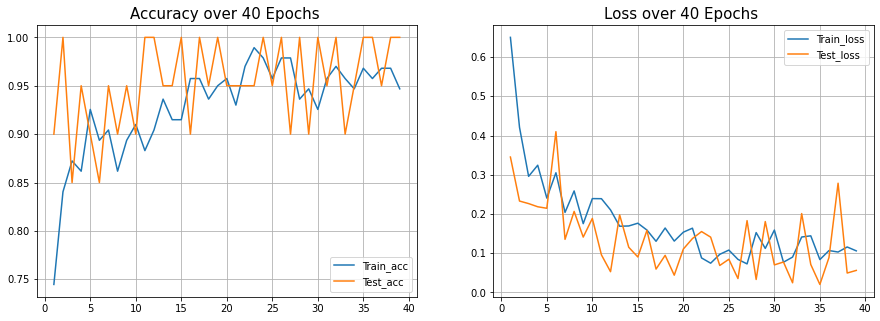

In [59]:
import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
 acc = result.history['acc']
 loss = result.history['loss']
 val_acc = result.history['val_acc']
 val_loss = result.history['val_loss']
 plt.figure(figsize=(15, 5))
 plt.subplot(121)
 plt.plot(range(1,40), acc[1:], label='Train_acc')
 plt.plot(range(1,40), val_acc[1:], label='Test_acc')
 plt.title('Accuracy over ' + str(epochs) + ' Epochs ', size=15)
 plt.legend()
 plt.grid(True)
 plt.subplot(122)
 plt.plot(range(1,40), loss[1:], label='Train_loss')
 plt.plot(range(1,40), val_loss[1:], label='Test_loss')
 plt.title('Loss over ' + str(epochs) + ' Epochs ', size=15)
 plt.legend()
 plt.grid(True)
 plt.show()
 
plot_acc_loss(result, 40)

#### Plot Test Results

Found 18 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
18/18 [==============================] - 2s 106ms/step
covid/nejmoa2001191_f3-PA.jpeg


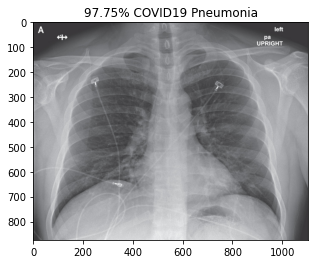

covid/nejmoa2001191_f4.jpeg


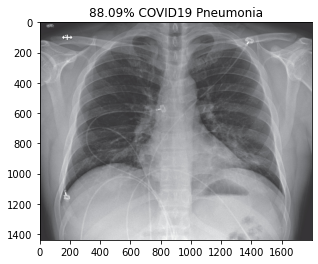

covid/nejmoa2001191_f5-PA.jpeg


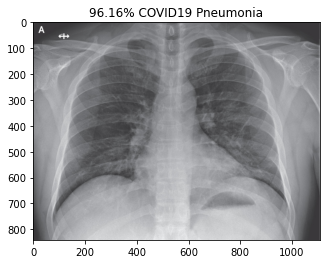

covid/radiol.2020200490.fig3.jpeg


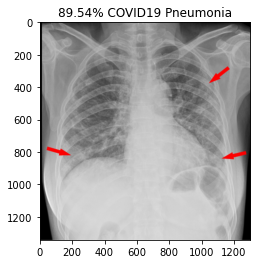

covid/ryct.2020200028.fig1a.jpeg


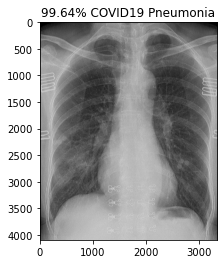

covid/ryct.2020200034.fig2.jpeg


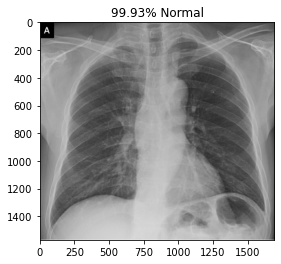

covid/ryct.2020200034.fig5-day0.jpeg


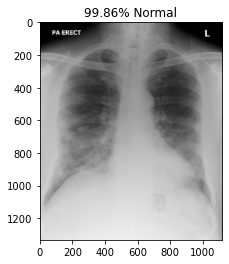

covid/ryct.2020200034.fig5-day4.jpeg


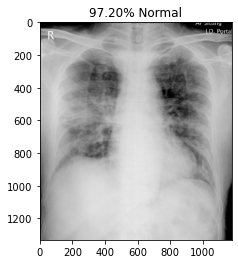

covid/ryct.2020200034.fig5-day7.jpeg


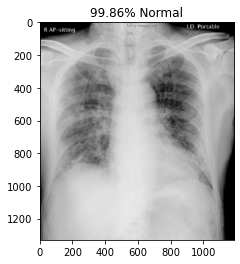

normal/NORMAL2-IM-1385-0001.jpeg


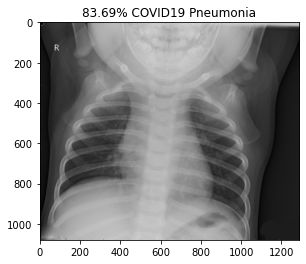

normal/NORMAL2-IM-1396-0001.jpeg


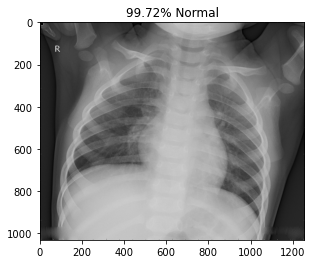

normal/NORMAL2-IM-1400-0001.jpeg


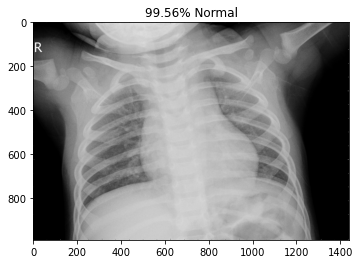

normal/NORMAL2-IM-1401-0001.jpeg


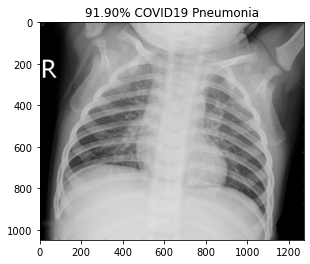

normal/NORMAL2-IM-1406-0001.jpeg


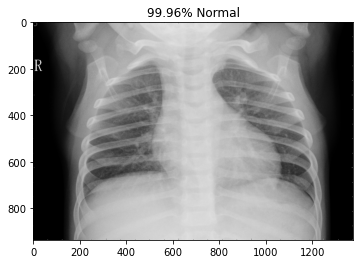

normal/NORMAL2-IM-1412-0001.jpeg


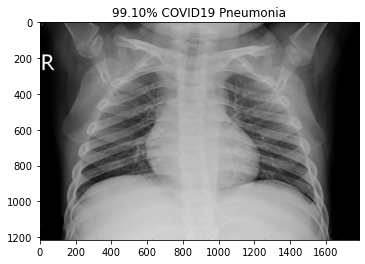

normal/NORMAL2-IM-1419-0001.jpeg


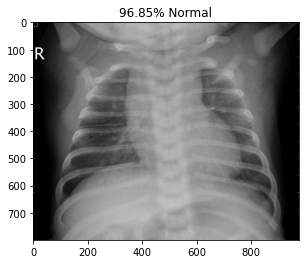

normal/NORMAL2-IM-1422-0001.jpeg


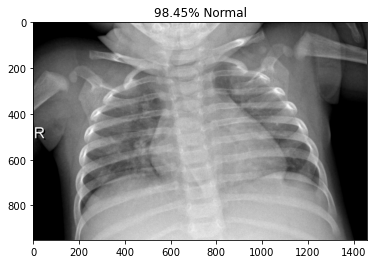

normal/NORMAL2-IM-1423-0001.jpeg


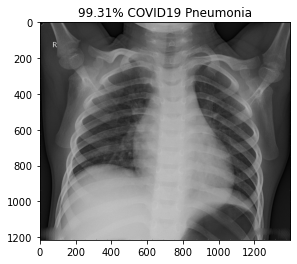

In [52]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
pred = model_base.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [56]:
from sklearn.manifold import TSNE

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_feature').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")



NameError: name 'models' is not defined

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->